In [22]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from utils import *
update_plot_defaults()
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Current-Voltage relationship (I-V)

## 1. Choose the data file you want to analyze

In [23]:
pathToData = "data/"
data_folders = glob(pathToData+"*") # The glob function helps you filter your files
print("Data folders:")
data_folders

Data folders:


['data/K_channels',
 'data/single_channel_recordings',
 'data/20240610_Ca+channel',
 'data/20240612_Slice_day_1',
 'data/Protocol Day 1.pro',
 'data/Voltage Clamp 1 MEO.pro',
 'data/Current Clamp 1.pro',
 'data/Fig_Cav',
 'data/20240618_opto',
 'data/Voltage Clamp 1.pro',
 'data/example_HEKA.dat',
 'data/Na_channels',
 'data/Data Presentation - CSHL Ion Channels.pptx',
 'data/link_to_data.txt',
 'data/20240614_Slice_evoked',
 'data/20240615_LFP',
 'data/20240617_LTP',
 'data/20240608_Na+channel',
 'data/striatum',
 'data/20240611_SingleChannel',
 'data/Fig_Kv']

In [24]:
data_files = glob(data_folders[0]+"/*.abf")
print(data_folders[0])
data_files

data/K_channels


['data/K_channels/2024_06_06_0002.abf',
 'data/K_channels/2024_06_08_0009.abf',
 'data/K_channels/2024_06_06_0000.abf',
 'data/K_channels/2024_06_06_0001.abf',
 'data/K_channels/2024_06_08_0008.abf',
 'data/K_channels/2024_06_08_0005.abf',
 'data/K_channels/2024_06_08_0011.abf',
 'data/K_channels/2024_06_08_0010.abf',
 'data/K_channels/2024_06_08_0004.abf',
 'data/K_channels/2024_06_08_0012.abf',
 'data/K_channels/2024_06_08_0006.abf',
 'data/K_channels/2024_06_08_0007.abf',
 'data/K_channels/2024_06_08_0013.abf',
 'data/K_channels/2024_06_08_0017.abf',
 'data/K_channels/2024_06_08_0003.abf',
 'data/K_channels/2024_06_08_0002.abf',
 'data/K_channels/2024_06_08_0016.abf',
 'data/K_channels/2024_06_08_0014.abf',
 'data/K_channels/2024_06_08_0015.abf',
 'data/K_channels/2024_06_08_0001.abf']

In [27]:
data_file = 'data/Na_channels/nav18-iv.abf'

(26, 2, 5160)
(5160,)
freq: 99999.99999999999 Hz


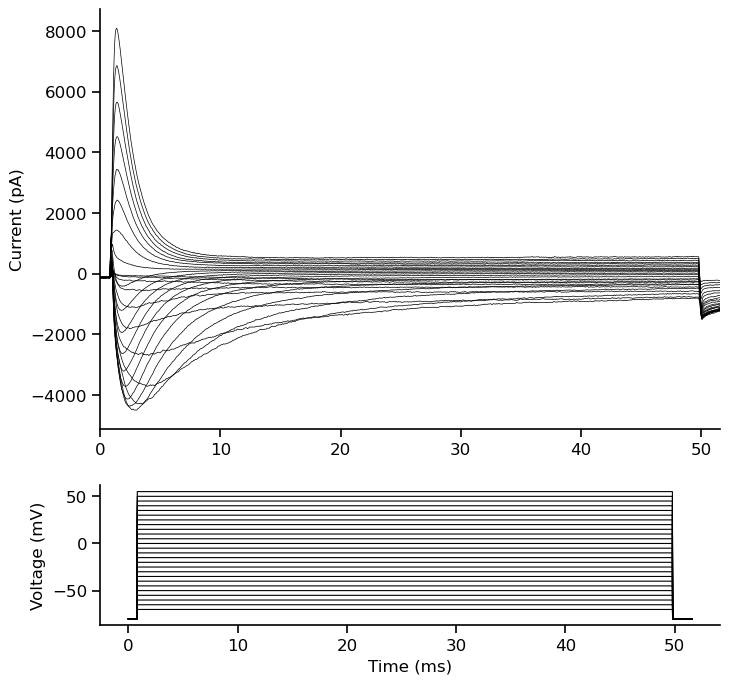

In [28]:
## Extract the sweeps, time and sampling frequency:
sweeps, sweeps_time, sampling_freq = get_sweeps(data_file)

print(sweeps.shape)
print(sweeps_time.shape)
print(f"freq: {sampling_freq} Hz")

current_traces = sweeps[:, 0, :]
voltage_traces = sweeps[:, 1, :]
plot_traces(sweeps_time, current_traces, voltage_traces)
plt.show()

## 2. Plot the traces to get an overview of the data

In [ ]:
start_time = 0 # milliseconds
end_time = 15 # milliseconds

marker_1 = 1.1 # milliseconds
marker_2 = 6 # milliseconds

current_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=0)
voltage_traces, time_in_window = select_sweep_window(sweeps, sweeps_time, start_time, end_time, sampling_freq, channel=1)

plot_traces(time_in_window, current_traces, voltage_traces, marker_1, marker_2)

## 3. Select what you want to measure:
- define the time window(s) of interest
- define what you want to measure (e.g. mean or peak voltage/current)

### 3.1. Optional: apply baseline correction

In [ ]:
# # 1. Measure baseline
# start_time = 0 # milliseconds
# end_time = 0.5 # milliseconds
# measurement_type = 'mean' # Options: 'mean', 'max', 'min'

# baseline_voltage, baseline_current = get_step_measurements(sweeps, sweeps_time, start_time, end_time, sampling_freq, measurement_type)

# # 2. Subtract baseline from the sweeps
# num_traces = sweeps.shape[0]
# for i in range(num_traces):
#     sweeps[i,0] -= baseline_current[i]
#     # sweeps[i,1] -= baseline_voltage[i]

# plot_traces(time_in_window, current_traces, voltage_traces, marker_1, marker_2)

### 3.2. Measure currents/voltage steps

<Axes: xlabel='V (mV)', ylabel='I (pA)'>

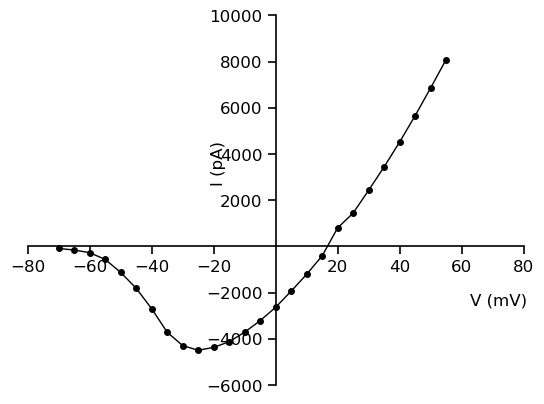

In [49]:
start_time = marker_1 # milliseconds
end_time = marker_2 # milliseconds
measurement_type = 'peak' # Options: 'mean', 'max', 'min', 'peak'

voltage_steps, current_steps = get_step_measurements(sweeps, sweeps_time, start_time, end_time, sampling_freq, measurement_type)

plot_IV(voltage_steps, current_steps, xlabel_coords=(0.95,0.25), ylabel_coords=(0.4,0.6))

### Optional: fit a line to the I-V points
#### get the intersection (reversal potential) and slope (conductance)

Resistance = 4.916 MOhm
Reversal potential: 17.298 mV


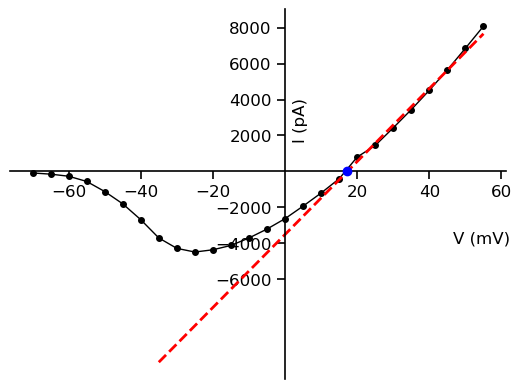

In [117]:
points_start = 17
points_end = -1

ax = plot_IV(voltage_steps, current_steps, xlabel_coords=(0.95,0.4), ylabel_coords=(0.6,0.7))

from scipy.stats import linregress
voltage_steps_to_fit = voltage_steps[points_start:points_end]
current_steps_to_fit = current_steps[points_start:points_end]
slope, intercept, r_value, p_value, std_err = linregress(voltage_steps_to_fit, current_steps_to_fit)
ax.plot(voltage_steps[7:], slope * voltage_steps[7:] + intercept, linestyle='--', color='r', label='Fit', linewidth=2)
print(f"Resistance = {1/slope * 1000:.3f} MOhm")

# Find the intercept on the x-axis (where current is zero)
V_rev = -intercept / slope
ax.scatter(V_rev, 0, color='b', zorder=5)
print(f"Reversal potential: {V_rev:.3f} mV")


### Calculate the channel activation curve 
#### (open probability of the channel, factoring in the changing driving force at different voltages)

<img src="images/Na_IV_activation_analysis.png" width="600">


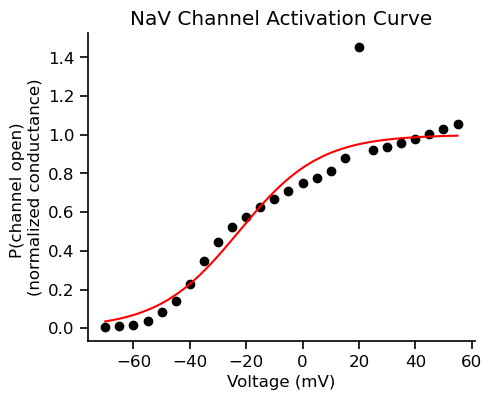

In [121]:
# Shift the values to the left so the reversal potential is at zero (i.e. curve passes through the origin)
# Then the conductance can be calculated at each point
G = current_steps / (voltage_steps - V_rev)

# **Note that we are estimating the G from single points. 
# --> Errors will be larger close to the reversal potential, where the denominator is small.**

# Now we normalize these conductances by the maximum value, i.e. the fully open channel conductance
# G_max = np.max(G) # We could use the maximum value, but this measurement is a bit noisy 
G_max = slope # We can also use the slope of the linear fit (in the open part of the curve) as the maximum conductance
G_norm = G / G_max

# Finally we can fit the Boltzmann function to the data (sigmoidal curve)
from scipy.optimize import curve_fit
def boltzmann(V, V_half, k):
    return 1 / (1 + np.exp((V_half - V) / k))
popt, _ = curve_fit(boltzmann, voltage_steps, G_norm, p0=[-20, 5])
V_half_fit, k_fit = popt
V_fit = np.linspace(np.min(voltage_steps), np.max(voltage_steps), 500)
G_fit = boltzmann(V_fit, V_half_fit, k_fit)

# Plot normalized data points & fitted curve
fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(voltage_steps, G_norm, 'o', label='Data', color='black')
ax.plot(V_fit, G_fit, '-', label='Boltzmann fit', color='red')
ax.set_xlabel('Voltage (mV)')
ax.set_ylabel('P(channel open) \n(normalized conductance)')
ax.set_title('NaV Channel Activation Curve')
plt.show()